# Convolution Benchmark

In [1]:
import math

import numba as nb
import numpy as np
from scipy.signal import windows, fftconvolve

try:  # cupy requires cuda and nvidia gpu
    import cupy as cp
except Exception as e:
    print("cupy did not load")
    cp = np

from util.helper import (
    padlr, realtime, square_and_hann_1d as square_and_hann, postprocess_df, compute_error
)

## Functions

The following techniques will be benchmarked by performing a single convolution of increasing size (number of samples).
- `Numba`
    - time domain
    - time domain (parallel)
- `Numpy`
    - time domain
    - freq domain (custom implementation)
- `Scipy`
    - freq domain
- `Cupy`
    - freq domain (GPU)

### Time Domain

In [2]:
def convolve_python(sig, win):
    m, n = len(win), len(sig)
    conv = [0.0 for _ in range(n)]
    norm = sum(win)
    for t in range(m, n):
        acc = 0.0
        for i, j in enumerate(range(t - m, t)):
            acc += win[i] * sig[j]
        conv[t] = acc / norm
    return conv[m:]


@nb.njit(fastmath=True)
def convolve_numba(sig, win):
    m, n = win.size, sig.size
    conv = np.zeros(n)
    norm = win.sum()
    for t in nb.prange(m, n):
        acc, i = 0.0, 0
        for j in nb.prange(t - m, t):
            acc += win[i] * sig[j]
            i += 1
        conv[t] = acc / norm
    return conv[m:]


@nb.njit(fastmath=True, parallel=True)
def convolve_numba_parallel(sig, win):
    m, n = win.size, sig.size
    conv = np.zeros(n)
    norm = win.sum()
    for t in nb.prange(m, n):
        acc, i = 0.0, 0
        for j in nb.prange(t - m, t):
            acc += win[i] * sig[j]
            i += 1
        conv[t] = acc / norm
    return conv[m:]


def convolve_np(sig, win):
    return np.convolve(sig, win, mode='same') / win.sum()

### Freq Domain

In [3]:
def convolve_fft_scipy(sig, win):
    return fftconvolve(sig, win, mode="same") / win.sum()


def convolve_fft_np(sig, win):
    pwin = np.pad(win, padlr((sig.size - win.size) / 2), mode="constant")
    fwin = np.fft.fft(pwin)
    fsig = np.fft.fft(sig)
    c = np.fft.ifft(fwin * fsig)
    return np.real(np.fft.fftshift(c)) / win.sum()


funcs = [
    convolve_python, convolve_numba, convolve_numba_parallel,
    convolve_np, convolve_fft_scipy, convolve_fft_np
]


if cp is not np:
    def convolve_fft_gpu(sig, win):
        pwin = cp.pad(win, padlr((sig.size - win.size) / 2), mode="constant").astype(cp.float32)
        fwin = cp.fft.fft(pwin)
        fsig = cp.fft.fft(sig)
        c = cp.fft.ifft(fwin * fsig)
        return cp.real(cp.fft.fftshift(c)) / win.sum()
    
    funcs.append(convolve_fft_gpu)

## Benchmark

In [4]:
from util.bench import Timer

t = Timer(funcs, square_and_hann, repeat=3, beg=7, end=25)
df = t.run(globals())
df = postprocess_df(df, t)

100%|████████████████████████████| 19/19 [01:59<00:00,  6.31s/it]


### Plot Results

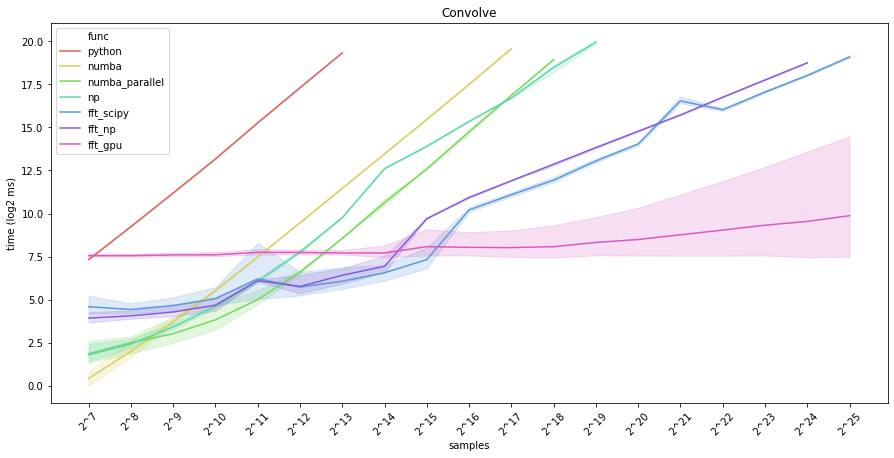

In [5]:
_ = t.plot_lin(df, size=(15, 7))

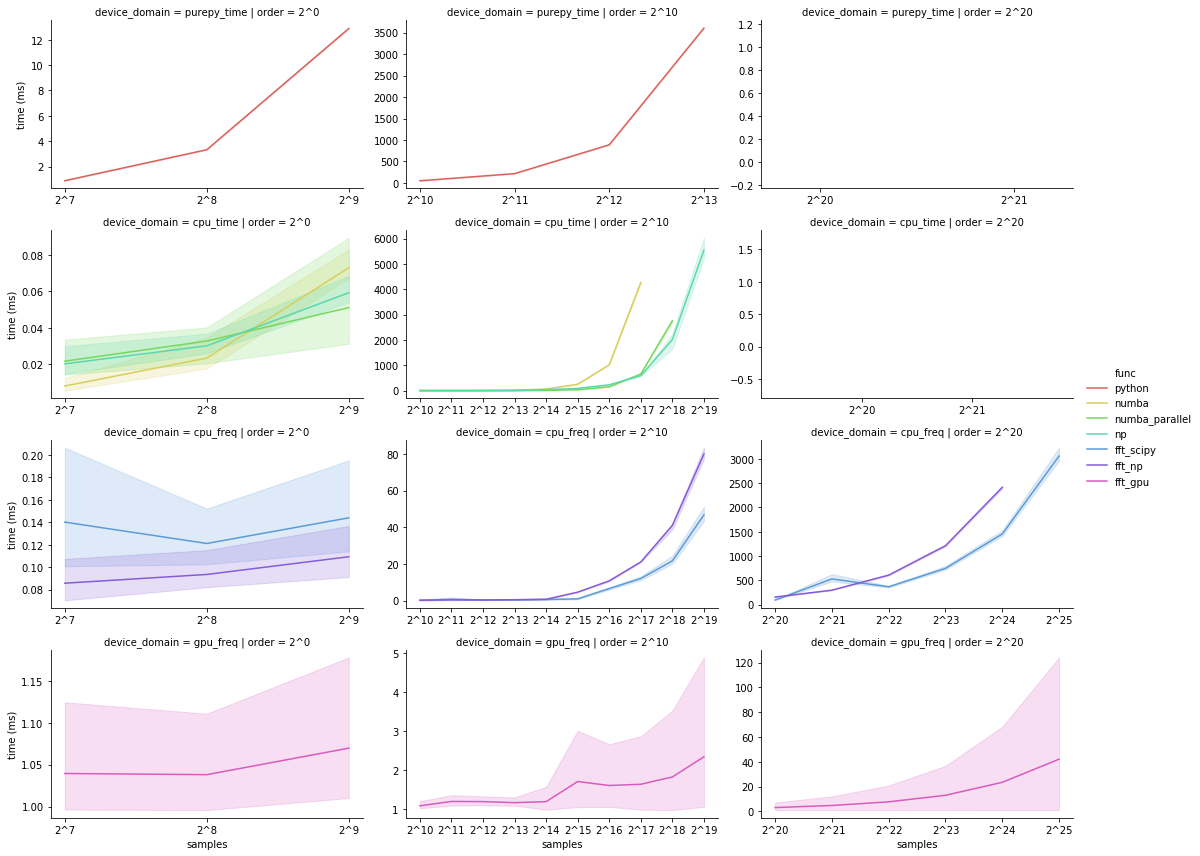

In [6]:
_ = t.plot_facet(df, row="device_domain")